### Analysis of Yelp data result

In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline

In [2]:
!ls -alt *.pkl

-rw-rw-r-- 1 huaqingj huaqingj    60214 Feb 11 06:03 MNARyelp_log45.pkl
-rw-rw-r-- 1 huaqingj huaqingj    60214 Feb 10 20:26 MARyelp_log45.pkl
-rw-rw-r-- 1 huaqingj huaqingj    80160 Feb 10 13:48 Ymat.pkl
-rw-rw-r-- 1 huaqingj huaqingj 41600163 Feb 10 13:48 Xsps.pkl
-rw-rw-r-- 1 huaqingj huaqingj  2080162 Feb 10 13:48 Xmat.pkl
-rw-rw-r-- 1 huaqingj huaqingj    60214 Feb 10 13:48 MNARyelp_log35.pkl
-rw-rw-r-- 1 huaqingj huaqingj    60214 Feb 10 13:48 MARyelp_log35.pkl


In [20]:
with open("./MARyelp_log45.pkl", "rb") as f:
#with open("./results/MARyelp_log35.pkl", "rb") as f:
    MARres = pickle.load(f)
    
with open("./MNARyelp_log45.pkl", "rb") as f:
#with open("./results/MNARyelp_log35_Xsps30k.pkl", "rb") as f:
    MNARres = pickle.load(f)

In [21]:
def AUCplot(MARres, MNARres, i, is_plot=False):
    marres,  mnarres = MARres[i], MNARres[i]
    marprobs, margts = marres[0].cpu().numpy(), marres[1].cpu().numpy()
    mnarprobs, mnargts = mnarres[0].cpu().numpy(), mnarres[1].cpu().numpy()
    marfpr, martpr, marthre = metrics.roc_curve(margts, marprobs)
    mnarfpr, mnartpr, mnarthre = metrics.roc_curve(mnargts, mnarprobs)
    marauc = metrics.roc_auc_score(margts, marprobs)
    mnarauc = metrics.roc_auc_score(mnargts, mnarprobs)
    if is_plot:
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(marfpr, martpr, "--r", label="MAR")
        plt.plot(mnarfpr, mnartpr, label="MNAR")
        plt.legend()
    return marauc, mnarauc
    

In [22]:
allaucs = [AUCplot(MARres, MNARres, i)  for i in range(1, 21)] 

In [23]:
allaucs = np.array(allaucs)
allaucdf = pd.DataFrame(allaucs)
allaucdf.columns = ["MAR", "MNAR"]
allaucdf

,MAR,MNAR
0,0.553094,0.533613
1,0.689305,0.574267
2,0.616190,0.609048
3,0.630769,0.592857
4,0.732243,0.727273
5,0.670759,0.640067
6,0.670982,0.578571
7,0.575669,0.506126
8,0.557623,0.528211
9,0.648331,0.585386


In [24]:
MARprobs = []
MARgt = []
MNARprobs = []
MNARgt = []
for i in range(1, len(MNARres)+1):
    mnarres = MNARres[i]
    MNARprobs.append(mnarres[0].cpu().numpy())
    MNARgt.append(mnarres[1].cpu().numpy())
for i in range(1, len(MARres)+1):
    marres = MARres[i]
    MARprobs.append(marres[0].cpu().numpy())
    MARgt.append(marres[1].cpu().numpy())

In [25]:
MARgt = np.concatenate(MARgt)
MNARgt = np.concatenate(MNARgt)
MARprobs = np.concatenate(MARprobs)
MNARprobs = np.concatenate(MNARprobs)

In [26]:
Data = {
    "Probs": np.concatenate([MNARprobs, MARprobs]),
    "Method": ["MNAR"] * len(MNARprobs) + ["MAR"] * len(MARprobs),
    "GT": np.concatenate([MNARgt, MARgt])
}
dfdata = pd.DataFrame(Data)

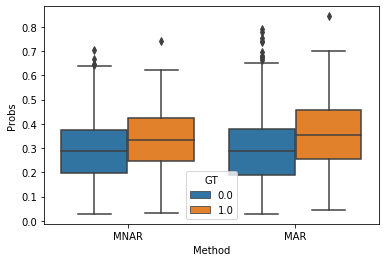

In [27]:
sns.boxplot(data=dfdata, x="Method", y="Probs", hue="GT")

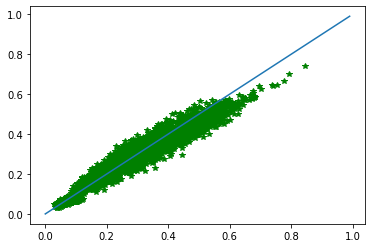

In [28]:
#plt.plot(MARgt[:200], "bo")
#plt.plot(MARgt[:200], MARprobs[:200], "rh")
#plt.plot(MARgt[:200], MNARprobs[:200], "g*")
plt.plot(MARprobs[:], MNARprobs[:], "g*")
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))

In [29]:
dfdatagrp = dfdata.groupby(["Method", "GT"])

In [30]:
dfdatagrp.describe()

Probs                                                    \
             count      mean       std       min       25%       50%   
Method GT                                                              
MAR    0.0  2183.0  0.289955  0.137955  0.029408  0.190930  0.286280   
       1.0   804.0  0.356324  0.139572  0.044135  0.256880  0.352576   
MNAR   0.0  2183.0  0.285898  0.126516  0.028712  0.198163  0.287649   
       1.0   804.0  0.333567  0.123869  0.030658  0.245180  0.334607   

                                
                 75%       max  
Method GT                       
MAR    0.0  0.378116  0.792216  
       1.0  0.455144  0.843120  
MNAR   0.0  0.375170  0.703036  
       1.0  0.422694  0.739804

In [14]:
from sklearn import metrics

In [15]:
metrics.roc_auc_score(MARgt, MARprobs)

0.6343614041564966

In [16]:
metrics.roc_auc_score(MNARgt, MNARprobs)

0.6049681733339715

In [17]:
marfpr, martpr, marthre = metrics.roc_curve(MARgt, MARprobs)
mnarfpr, mnartpr, mnarthre = metrics.roc_curve(MNARgt, MNARprobs)

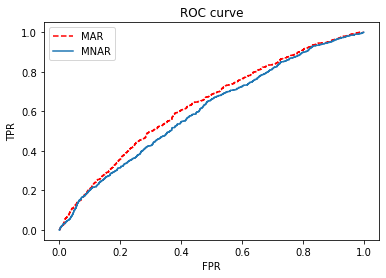

In [18]:
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(marfpr, martpr, "--r", label="MAR")
plt.plot(mnarfpr, mnartpr, label="MNAR")
plt.legend()

In [21]:
with open("Ymat.pkl", "rb") as f:
    Y = pickle.load(f)

In [23]:
Yno = Y[Y!=-1]

(array([  52.,    0.,  220.,    0.,    0.,  684.,    0., 1227.,    0.,
         804.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

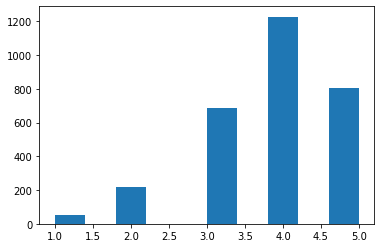

In [26]:
plt.hist(Yno)